In [1]:
!pip install -U scikit-learn
!pip install ffmpeg-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 22.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import multivariate_normal
import seaborn as sns

import sys
import os
import glob
from scipy.io import wavfile
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# will need these for audio recording & processing directly thru Colab (Part 3)
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
#from scipy.io import wavfile
import io
import ffmpeg
import librosa

#for processing images
from PIL import Image, ImageDraw
import cv2

In [3]:
# Initializing the random seed
random_seed=19

# PART I

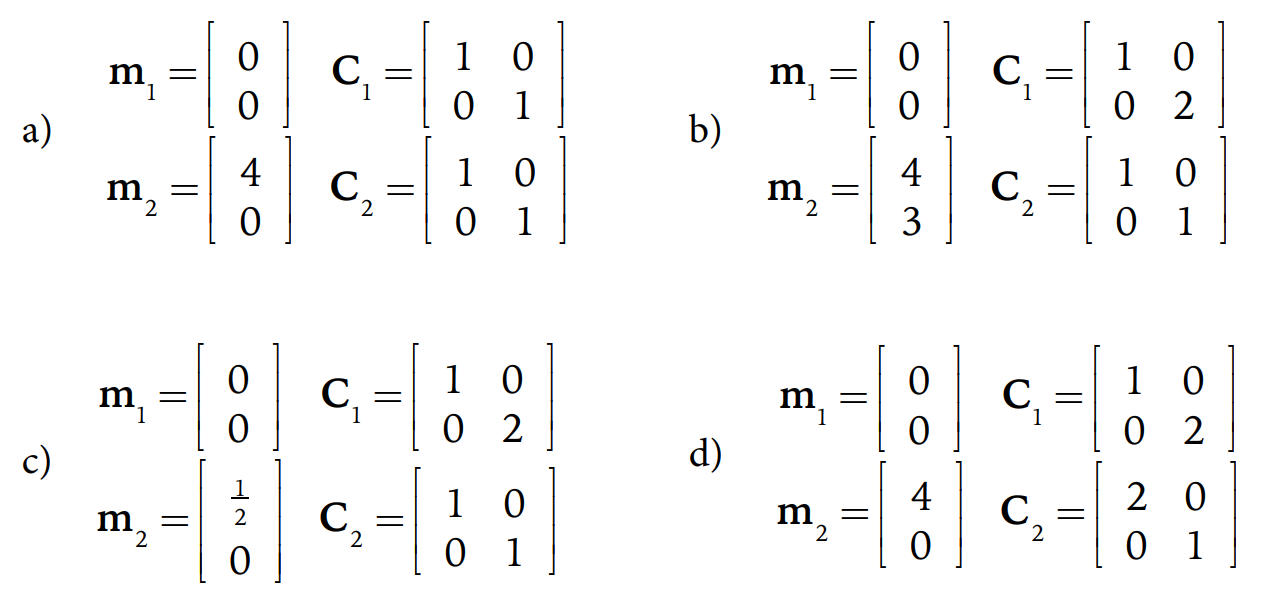

In [4]:
def plot_gaussians_and_discriminant (mean1, cov1, mean2, cov2, sub_q=''):

  # Generating a Gaussian bivariate distribution with given mean and covariance matrix
  gaussian1 = multivariate_normal(cov = cov1, mean = mean1,seed = random_seed)
  gaussian2 = multivariate_normal(cov = cov2, mean = mean2,seed = random_seed)
  # Generating 5000 samples out of the distributions
  data1 = gaussian1.rvs(size = 500)
  data2 = gaussian2.rvs(size = 500)
  # plot gaussians
  sns.kdeplot(data1, x=data1[:,0], y=data1[:,1], fill=True)
  sns.kdeplot(data2, x=data2[:,0], y=data2[:,1], fill=True)

  mean1 = mean1.reshape(-1,1)
  mean2 = mean2.reshape(-1,1)

  #define x1,x2 range with no of points
  x1 = np.linspace(-8,8,100).reshape(1,-1)
  x2 = np.linspace(-8,8,100).reshape(1,-1)
  x1, x2 = np.meshgrid(x1, x2)
  x  = np.concatenate((x1.reshape(1,-1),x2.reshape(1,-1)),axis=0)

  # Writing the discriminant function for arbitrary (i.e. not sigma @ I) cov matrix for class 1
  cov1_inv = np.linalg.inv(cov1)
  W1_second_order = - 0.5 * cov1_inv
  w1_first_order  = cov1_inv @ mean1
  w1_const        = - 0.5 * mean1.T @ cov1_inv @ mean1 - 0.5 * np.log(np.linalg.det(cov1)) + np.log(0.5) # assuming equal priors
  g1 = np.diag(x.T @ W1_second_order @ x) + w1_first_order.T @ x + w1_const

  # Writing the discriminant function for arbitrary cov matrix for class 2
  cov2_inv = np.linalg.inv(cov2)
  W2_second_order = - 0.5 * cov2_inv
  w2_first_order  = cov2_inv @ mean2
  w2_const        = - 0.5 * mean2.T @ cov2_inv @ mean2 - 0.5 * np.log(np.linalg.det(cov2)) + np.log(0.5) # assuming equal priors
  g2 = np.diag(x.T @ W2_second_order @ x) + w2_first_order.T @ x + w2_const

  g = g1 - g2
  g = g.reshape(int(np.sqrt(g.shape[1])),int(np.sqrt(g.shape[1])))

  plt.contour(x1, x2, g, levels=[0])
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.title(f'Two dimensional Gaussians & their discriminant in ({sub_q})')
  plt.axis('equal')
  plt.show()

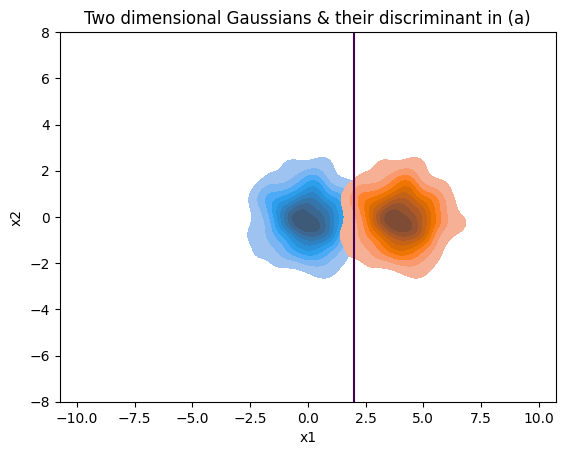

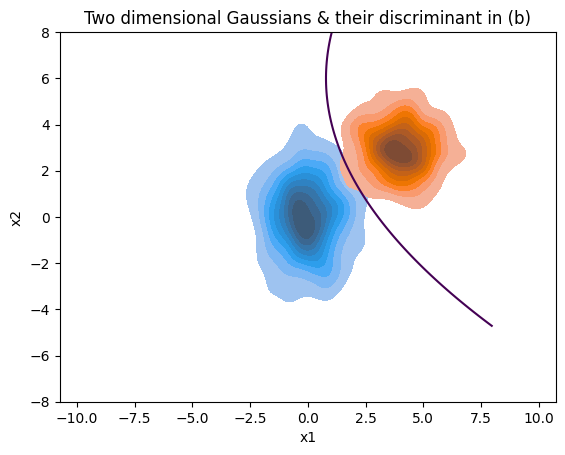

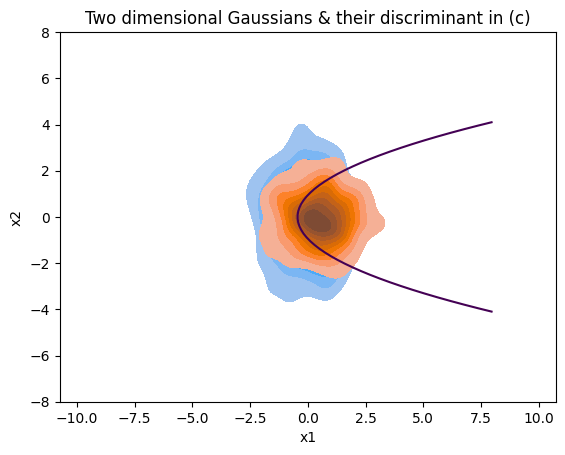

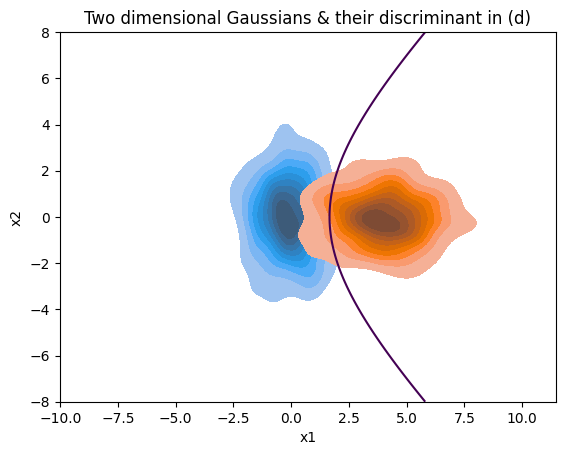

In [5]:
# Initializing the mean & covariance matrices & plotting them

# (a)
mean1 = np.array([0,0])
cov1 = np.eye(2,2)
mean2 = np.array([4,0])
cov2 = np.eye(2,2)
plot_gaussians_and_discriminant(mean1, cov1, mean2, cov2, 'a')

# (b)
mean1 = np.array([0,0])
cov1 = np.array([[1, 0],[0, 2]])
mean2 = np.array([4,3])
cov2 = np.eye(2,2)
plot_gaussians_and_discriminant(mean1, cov1, mean2, cov2, 'b')

# (c)
mean1 = np.array([0,0])
cov1 = np.array([[1, 0],[0, 2]])
mean2 = np.array([0.5,0])
cov2 = np.eye(2,2)
plot_gaussians_and_discriminant(mean1, cov1, mean2, cov2, 'c')

# (d)
mean1 = np.array([0,0])
cov1 = np.array([[1, 0],[0, 2]])
mean2 = np.array([4,0])
cov2 = np.array([[2, 0],[0, 1]])
plot_gaussians_and_discriminant(mean1, cov1, mean2, cov2, 'd')

# PART II

In [6]:
!gdown "https://drive.google.com/uc?export=download&id=1CIyShhUVdYXIMQhbPwZSnvjn7i_IK3tX" -O digit-labels.npz
#https://drive.google.com/file/d/1CIyShhUVdYXIMQhbPwZSnvjn7i_IK3tX/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?export=download&id=1CIyShhUVdYXIMQhbPwZSnvjn7i_IK3tX
To: /content/digit-labels.npz
100% 3.13M/3.13M [00:00<00:00, 183MB/s]


In [7]:
digit_labels = np.load('digit-labels.npz') # archive of files
images = digit_labels['d']  # ndarray
labels = digit_labels['l']  # ndarray
# can check what files exist in an npz archive using:
#for file in digit_labels.files:
#    print(file)
# sanity check
#plt.imshow(np.reshape(images[:,0],(28,28),'F'))

In [8]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [9]:
def train_test_split(images, labels, n_per_label=100):
    train_indices = np.empty(0, dtype=np.int8)
    for label in np.unique(labels).tolist():
        # for each label
        indices = np.where(labels == label)[0]
        #print(label, indices.shape)
        # sample 100 indices randomly from images & labels
        rng = np.random.default_rng()
        indices_100 = rng.choice(indices, size=n_per_label, replace=False, shuffle=False)  # shuffle=False only for a speedup
        # add to train indices
        train_indices = np.append(train_indices, indices_100)

    # store images & labels corresponding to train_indices in train
    train_images = np.take(images, train_indices, axis=1)
    train_labels = np.take(labels, train_indices)
    # store remaining images & labels in test
    test_images = np.delete(images, train_indices, axis=1)
    test_labels = np.delete(labels, train_indices)

    return train_images, train_labels, test_images, test_labels

In [10]:
train_images, train_labels, test_images, test_labels = train_test_split(images, labels)

In [11]:
# Principal Component Analysis (PCA) by eigenvector decomposition of COV matrix
def get_pca_components(X, k=3):
  # expects X to be of shape (d, N)
  # returns eig_vecs of COV which are PCA components of X of shape
  # (d,k) where k is the desired dimensionality of pca-ed data

  # Make X zero mean (could have also done with mean of whole X rather than with mean column)
  X_mean = np.mean(X,axis=1)
  X = X - X_mean.reshape(-1,1)
  assert np.mean(X) <= 1e-7
  # Compute Covariance matrix for X
  COV = np.matmul(X, np.transpose(X))  # a symmetric (thus square) positive semi-definite matrix
  # Eigendecomposition of COV to find (right) eigenvectors
  eig_values, eig_vecs = scipy.sparse.linalg.eigs(COV, k=k) # (columns of) eig_vecs are the P.C vectors
  return eig_values, eig_vecs  # eig_vecs are the principal components

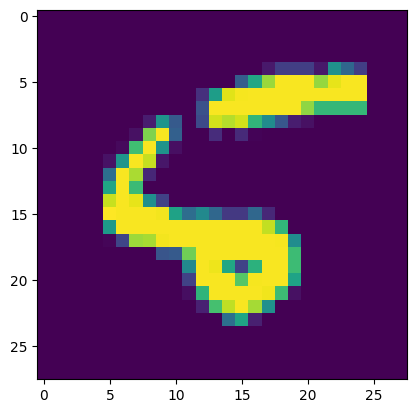

In [12]:
plt.imshow(np.reshape(test_images[:,6],(28,28),'F'))

In [13]:
train_mean = np.mean(train_images, axis=1).reshape(-1,1)

In [14]:
# PCA for image (digit) vectors
mean_list = []
cov_list = []
#get pca components for the image data of the current digit label
eig_values, train_images_pca_components = get_pca_components(train_images, k=30)
eig_values_inv = np.linalg.inv(np.diag(np.sqrt(np.real(eig_values))))
#convert image data to pca space
train_images_pcaed = eig_values_inv @ train_images_pca_components.T @ (train_images - train_mean) # shape (k,N)
for i in range(10):
  #get data relevant to current label
  train_images_pcaed_of_current_label = train_images_pcaed[:,100*i:100*i+100] # shape (k,N)
  #find empirical mean --> shape (k,1)
  mean_pca_image_for_current_label = np.mean(train_images_pcaed_of_current_label, axis=1)
  #find empriical cov matrix --> shape (k,k)
  cov_for_current_label = np.cov(train_images_pcaed_of_current_label)
  #add mean, cov to lists
  mean_list.append(mean_pca_image_for_current_label)
  cov_list.append(cov_for_current_label)

We have now found out the per class empirical mean, empirical covariance of the assumed Gaussian distributions over every class

Now, given an image vector, we need to find the Gaussian that "most explains" the image vector and assign it that class

From Bayesian principles, since the prior probability of a given image vector (X) is remains constant (1/test_size) and the prior probability of a given class remains constant (1/100) we could use the fact that the P(class / X) = const * P(X/class)

A measure of P(X/class) can be found out using the formula for probability of multivariate Gaussians and taking log over it (monotonically increasing) to ease computation. Constants can be disregarded since they will, in effect, only "scale" the probabilities up or down by a constant factor

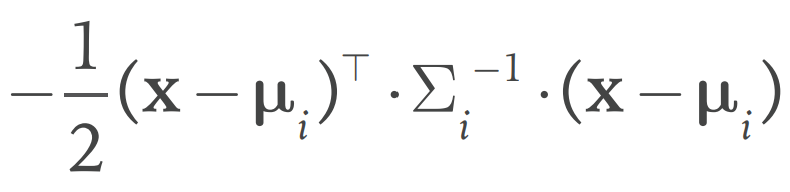

In [15]:
def pred_using_prob_score(X, mean_list, cov_list):
  # X should be of shape (k,1)
  # mean in mean_list should be of shape (k,1)
  # cov in cov_list should be of shape (k,k)
  X = X.reshape(-1,1)
  prob_scores = []
  for i in range(10):
    mean = mean_list[i].reshape(-1,1)
    cov  = cov_list[i]
    # covert X to pca space of label under consideration
    X_pcaed = eig_values_inv @ train_images_pca_components.T @ (X - train_mean)
    #print(f"(X-mean).shape: {(X-mean).shape}, np.linalg.inv(cov).shape: {np.linalg.inv(cov).shape}") --> error in cov.shape
    prob_scores.append(- 0.5 * (X_pcaed-mean).T @ np.linalg.inv(cov) @ (X_pcaed-mean))
  most_probable_label = prob_scores.index(max(prob_scores))
  return most_probable_label

In [16]:
correct = 0
total = 0
for j in range(10):
  for k in range(100):
    pred = pred_using_prob_score(train_images[:,100*j+k], mean_list, cov_list)
    if pred==train_labels[100*j+k]:
      #plt.imshow(np.reshape(train_images[:,100*j],(28,28),'F'))
      #plt.show()
      correct+=1
      total+=1
    else:
      #plt.imshow(np.reshape(train_images[:,100*j],(28,28),'F'))
      #plt.show()
      #print(f"Wrong prediction: {pred}, correct is {train_labels[100*j+k]}")
      total+=1
print(f"Training accuracy on {total} images is {(correct*1.0)/total *100}%")

Training accuracy on 1000 images is 98.6%


In [17]:
correct = 0
total = 0
for j in range(10):
  # find indices of images corresponding to digit j
  indices_of_test_label_j = np.where(test_labels == j)[0]
  # get those image data
  test_images_j = test_images[:,indices_of_test_label_j]  # shape (d,N_j)
  for k in range(test_images_j.shape[1]):
    pred = pred_using_prob_score(test_images_j[:,k], mean_list, cov_list)
    if pred==j:
      #plt.imshow(np.reshape(test_images_j[:,k],(28,28),'F'))
      #plt.show()
      correct+=1
      total+=1
    else:
      #plt.imshow(np.reshape(test_images_j[:,k],(28,28),'F'))
      #plt.show()
      #print(f"Wrong prediction: {pred}, correct is {j}")
      total+=1
print(f"Testing accuracy on {total} images is {(correct*1.0)/total *100}%")

Testing accuracy on 9000 images is 89.55555555555556%


By varying the number of PCA components we consider (k), we change the dimensionality of the PCA'ed image data.

We observe that, in general, our probability based classifier is able to perform better when k is higher & we need k >= 20 to get an accuracy of over 90% on the testing data. This is because, conceptually, it can find more "dimensions" for discrmination between classes

Interestingly, higher values of k do not necessarily yield better accurarcy on testing data. A possible explanation is that after 20 principal component dimensions, the variance explained by these dimensions is not very high; and thus do not enable better discrimination between classes. This can be verified by comparing the first 20 eigenvalues with the last 5 (for say, k=30)

In [18]:
np.abs(eig_values[:11]), np.abs(eig_values[-5:])

(array([5041.84299555, 3944.46141909, 3359.33110627, 2957.59792549,
        2828.69521787, 2342.64802124, 1827.95927222, 1623.88589972,
        1439.27671788, 1259.03311521, 1166.34096541]),
 array([448.88645986, 426.0793174 , 414.84671612, 383.25956907,
        360.90962372]))

# PART III

In [19]:
!gdown "https://drive.google.com/uc?export=download&id=1O9MbCrLGTytxZbkJ1C-68SOBNasgJUU2" -O SpeechMusic.zip
#https://drive.google.com/file/d/1O9MbCrLGTytxZbkJ1C-68SOBNasgJUU2/view

Downloading...
From: https://drive.google.com/uc?export=download&id=1O9MbCrLGTytxZbkJ1C-68SOBNasgJUU2
To: /content/SpeechMusic.zip
100% 73.6M/73.6M [00:01<00:00, 55.7MB/s]


In [20]:
!unzip -q SpeechMusic.zip

In [21]:
folder_path = './SpeechMusic/music'
music_files = glob.glob(os.path.join(folder_path, '*.wav'))
music_list = []
for wav_file in music_files:
  wav_samplerate, wav_data = wavfile.read(wav_file)
  wav_data = np.array(wav_data, dtype=float) # each array is of shape (330750,)
  music_list.append(wav_data)
  #sanity check
  #print(wav_data, type(wav_data[0])) # audio as numbers
  #print(f"wav_samplerate is {wav_samplerate}")  # sampling rate is always 22050
  #wav_length_time = wav_data.shape[0]/wav_samplerate
  #print(f"length of audio: {wav_length_time} seconds")  # audio file length is always 15s

In [22]:
folder_path = './SpeechMusic/speech'
speech_files = glob.glob(os.path.join(folder_path, '*.wav'))
speech_list = []
for wav_file in speech_files:
  wav_samplerate, wav_data = wavfile.read(wav_file)
  wav_data = np.array(wav_data, dtype=float) # each array is of shape (330750,)
  speech_list.append(wav_data)

In [23]:
# Create window
window_size = 22050 # 330750/15 (decrease to get more training data), don't go above equivalent of 1 sec of audio
hamming_window = np.hamming(window_size)
overlap = window_size * 1/2  # increase overlap to get more training data (spectogram vectors)

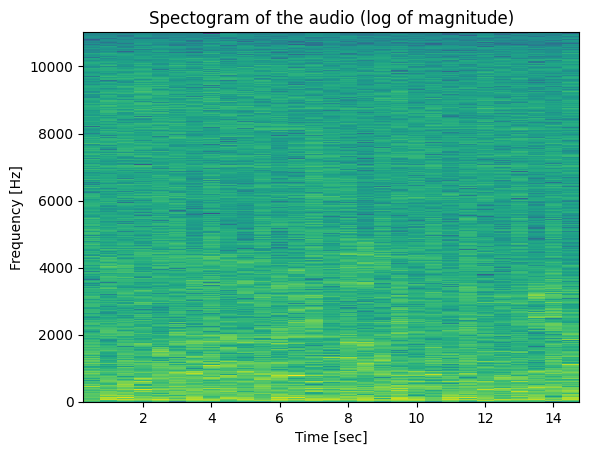

In [24]:
Sxx_music = 0
flag = 1
for wav_data in music_list:
  # Compute spectogram using Scipy & visualize using matplotlib
  f, t, Sxx = scipy.signal.spectrogram(wav_data, fs=wav_samplerate, window=hamming_window, noverlap=overlap, mode='magnitude')
  Sxx = np.log(Sxx)
  if flag == 1:
    Sxx_music = Sxx
    flag = 0
  else:
    Sxx_music = np.append(Sxx_music, Sxx, axis = 1)
plt.pcolormesh(t, f, Sxx, shading='auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectogram of the audio (log of magnitude)')
plt.show()

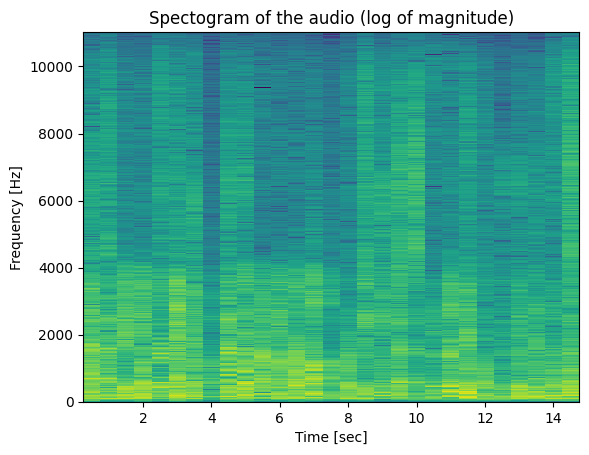

In [25]:
Sxx_speech = 0
flag = 1
for wav_data in speech_list:
  # Compute spectogram using Scipy & visualize using matplotlib
  f, t, Sxx = scipy.signal.spectrogram(wav_data, fs=wav_samplerate, window=hamming_window, noverlap=overlap, mode='magnitude')
  Sxx = np.log(Sxx)
  if flag == 1:
    Sxx_speech = Sxx
    flag = 0
  else:
    Sxx_speech = np.append(Sxx_speech, Sxx, axis = 1)
plt.pcolormesh(t, f, Sxx, shading='auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectogram of the audio (log of magnitude)')
plt.show()

In [26]:
Sxx.shape, Sxx_music.shape, Sxx_speech.shape

((11026, 29), (11026, 1740), (11026, 1741))

In [27]:
qqq = np.ones((3,3))
lll = [1,2,3]
print(lll*qqq)

[[1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]]


## Adaboost

In [28]:
# Adaboost algorithm

def adaboost(X, y, num_classifiers, num_epochs=1):
  """
  X is the data of shape (n_features,n_samples), y -> predictions
  """
  n_features, n_samples = X.shape
  weights = np.full(n_samples, 1/n_samples).reshape(1,-1) # equally weigh all points initially
  classifiers = [] # (classifier, alpha) tuple
  #alphas = []

  for _ in range(num_classifiers):
    # Train each weak classifier, i.e., decision stump
    classifier = train_weak_classifier(X, y, weights, epochs=num_epochs) # how many epochs

    # Make predictions on newest classifier only
    y_pred = np.sign(classifier @ np.concatenate((X,np.ones((1,X.shape[1]))), axis=0))  # Convert to binary predictions (-1 or 1)

    # Calculate weighted error for newest classifier
    error = np.sum(weights * (y != y_pred))
    if error>0.5:
      continue # we want weak classifiers to be at least slightly better than random on our training data

    # Calculate alpha (weight of newest classifier in final decision)
    alpha = 0.5 * np.log((1 - error) / max(error, 1e-10))
    #print(f"alpha: {alpha}")
    #print(f"Error {_}: {error} & alpha: {alpha}")

    # Add the new classfier & its alpha
    classifiers.append((classifier, alpha))

    # Update weights for next classifier stump
    overall_y_pred = y_pred * 0
    for classifier, alpha in classifiers:
      y_pred = np.sign(classifier @ np.concatenate((X,np.ones((1,X.shape[1]))), axis=0))  # Convert to binary predictions (-1 or 1)
      overall_y_pred += alpha * y_pred
    overall_y_pred = np.sign(overall_y_pred)
    weights = weights * np.exp(-alpha * y * overall_y_pred)
    weights /= np.sum(weights)  # normalize weights
    #print(weights[:5], np.min(weights), np.max(weights))

  return classifiers # (classifier, alpha) tuple

# Example weak classifier (you can replace this with your own)
def train_weak_classifier(X, y, sample_weights, epochs):
  X = np.concatenate((X, np.ones((1,X.shape[1]))),axis=0) # for bias
  n_features = X.shape[0]
  w = np.random.randn(1,n_features)
  for epoch in range(epochs):
    lr = 1000/(10000+epoch) * sample_weights
    y_pred = np.sign(w @ X)  # (1, n_samples)
    incorrect_indices = np.where(y_pred!=y)[1] #[1] since both y & y_pred will be (1, n)
    w += (np.sum((lr[:, incorrect_indices] * y[:, incorrect_indices] * X[:, incorrect_indices]), axis=1)).T # perceptron update rule
  return w

In [29]:
num_classifiers = 5 # Number of weak classifiers
X = np.concatenate((Sxx_speech,Sxx_music), axis=1)
X = X - np.mean(X)
X = X/np.std(X)
y = np.concatenate(( -1*np.ones((1,Sxx_speech.shape[1])), np.ones((1,Sxx_music.shape[1]))), axis=1)
classifiers = adaboost(X, y, num_classifiers, num_epochs=100)

In [30]:
def run_test(classifiers, X_train, y_train, X_test, y_test):
  # Make predictions using the ensemble of weak classifiers

  overall_y_pred = y_train * 0  # train init
  for classifier, alpha in classifiers:
    y_pred = np.sign(classifier @ np.concatenate((X_train,np.ones((1,X_train.shape[1]))), axis=0))  # concat 1 for bias
    #print(f"Accuracy of individual classifier: {np.mean(y_pred == y_train)*100:.2f}%")
    overall_y_pred += alpha * y_pred

  overall_y_pred = np.sign(overall_y_pred)
  train_accuracy = np.mean(overall_y_pred == y_train)

  overall_y_pred = y_test * 0  # test init
  for classifier, alpha in classifiers:
    y_pred = np.sign(classifier @ np.concatenate((X_test,np.ones((1,X_test.shape[1]))), axis=0))  # concat 1 for bias
    overall_y_pred += alpha * y_pred

  overall_y_pred = np.sign(overall_y_pred)
  test_accuracy = np.mean(overall_y_pred == y_test)


  return train_accuracy, test_accuracy

In [31]:
X = np.concatenate((Sxx_speech,Sxx_music), axis=1)
X = X - np.mean(X)
X = X/np.std(X)
y = np.concatenate(( -1*np.ones((1,Sxx_speech.shape[1])), np.ones((1,Sxx_music.shape[1]))), axis=1)
# let's shuffle the training data & classes
shuffled_indices = np.random.permutation(X.shape[1])
X = X[:, shuffled_indices]
y = y[:, shuffled_indices]

num_classifiers = 5 # Number of weak classifiers
start_index = 0
jump = X.shape[1]//10
for itr in range(10):
  test_indices = np.array(range(start_index, start_index+jump))
  X_test = X[:, test_indices]
  y_test = y[:, test_indices]
  X_train = np.delete(X, test_indices, axis=1)
  y_train = np.delete(y, test_indices, axis=1)
  classifiers = adaboost(X_train, y_train, num_classifiers, num_epochs=100)
  train_accuracy, test_accuracy = run_test(classifiers, X_train, y_train, X_test, y_test)
  print(f"Training accuracy of ensemble in train/test set {itr+1} is {train_accuracy*100:.2f}%")
  print(f"Testing accuracy of ensemble in train/test set {itr+1} is {test_accuracy*100:.2f}%\n")
  start_index += jump

Training accuracy of ensemble in train/test set 1 is 81.87%
Testing accuracy of ensemble in train/test set 1 is 80.75%

Training accuracy of ensemble in train/test set 2 is 86.12%
Testing accuracy of ensemble in train/test set 2 is 81.61%

Training accuracy of ensemble in train/test set 3 is 79.03%
Testing accuracy of ensemble in train/test set 3 is 75.29%

Training accuracy of ensemble in train/test set 4 is 75.45%
Testing accuracy of ensemble in train/test set 4 is 70.69%

Training accuracy of ensemble in train/test set 5 is 86.88%
Testing accuracy of ensemble in train/test set 5 is 86.49%

Training accuracy of ensemble in train/test set 6 is 86.02%
Testing accuracy of ensemble in train/test set 6 is 84.20%

Training accuracy of ensemble in train/test set 7 is 82.54%
Testing accuracy of ensemble in train/test set 7 is 77.87%

Training accuracy of ensemble in train/test set 8 is 81.26%
Testing accuracy of ensemble in train/test set 8 is 79.31%

Training accuracy of ensemble in train/t

In [32]:
classifiers = adaboost(X, y, num_classifiers, num_epochs=100) # train on entire data

In [33]:
run_test(classifiers, X, y, X, y)  # (train_acc, test_acc)

(0.8425739729962655, 0.8425739729962655)

In general, I've observed that the performance of the ensemble is sensitive to the learning rate of the perceptron algorithm

## SKLEARN baseline

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [35]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.T, y.T, test_size=0.2, random_state=random_seed)

In [36]:
base_estimator2 = Perceptron(max_iter=100, verbose=0)
n_estimators2 = 5  # Number of weak classifiers
adaboost2 = AdaBoostClassifier(estimator=base_estimator2, n_estimators=n_estimators2, algorithm='SAMME')
adaboost2.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME', estimator=Perceptron(max_iter=100),
                   n_estimators=5)

In [37]:
y_pred2 = adaboost2.predict(X_test)
accuracy2 = accuracy_score(y_test, y_pred2)
print(f"Accuracy with Perceptrons: {accuracy2}")
#alpha_values = adaboost2.estimator_weights_
#print("Alpha values for the Peceptron stumps:", alpha_values)

Accuracy with Perceptrons: 0.9598278335724534


## CUSTOM AUDIO

In [38]:
# Source: https://ricardodeazambuja.com/deep_learning/2019/03/09/audio_and_video_google_colab/

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wavfile.read(io.BytesIO(riff))

  return audio, sr

In [39]:
# uncomment for recording your own audio via Colab
"""audio1, sr1 = get_audio()
audio1 = np.array(audio1, dtype=float)
print(classify_audio_with_adaboost_ensemble(audio1, sr1, wav_samplerate))"""

'audio1, sr1 = get_audio()\naudio1 = np.array(audio1, dtype=float)\nprint(classify_audio_with_adaboost_ensemble(audio1, sr1, wav_samplerate))'

In [40]:
def classify_audio_with_adaboost_ensemble(audio1, sr1, wav_samplerate):
  # prune to 15 secs & downsample to Hz
  # Reference: https://stackoverflow.com/questions/30619740/downsampling-wav-audio-file
  if sr1 > wav_samplerate : audio1 = librosa.resample(audio1, orig_sr=sr1, target_sr=wav_samplerate)
  elif sr1<wav_samplerate : audio1 = librosa.upsample(audio1, orig_sr=sr1, target_sr=wav_samplerate)

  _, _, Sxx_audio1 = scipy.signal.spectrogram(audio1, fs=wav_samplerate, window=hamming_window, noverlap=overlap, mode='magnitude')
  Sxx_audio1 = np.log(Sxx_audio1)

  X = Sxx_audio1 - np.mean(Sxx_audio1)
  X = X / np.std(X)
  overall_y_pred = np.zeros((1,Sxx_audio1.shape[1])) # test init
  for classifier, alpha in classifiers:
    y_pred = np.sign(classifier @ np.concatenate((X,np.ones((1,X.shape[1]))), axis=0))  # concat 1 for bias
    overall_y_pred += alpha * y_pred

  overall_y_pred = np.sign(overall_y_pred)

  if overall_y_pred.mean()>0 :
    return f"music" #, {overall_y_pred.mean()}"
  elif overall_y_pred.mean()<0 :
    return f"speech" #, {overall_y_pred.mean()}"
  return "decision difficult"

In [41]:
!gdown --q "https://drive.google.com/uc?export=download&id=1MfI-dJBTwqCkGHDx6btuDBINwVgpOeTC" -O audio1.wav
#https://drive.google.com/file/d/1MfI-dJBTwqCkGHDx6btuDBINwVgpOeTC/view?usp=share_link -- speech

!gdown --q "https://drive.google.com/uc?export=download&id=1aXfsHD-gUIKOLgYFEal2lGhFRodAVqLU" -O audio2.wav
#https://drive.google.com/file/d/1aXfsHD-gUIKOLgYFEal2lGhFRodAVqLU/view?usp=share_link -- music

!gdown --q "https://drive.google.com/uc?export=download&id=13RgIZ06bNqh0SRdD1ahTx4oSJIjn-bWM" -O audio3.wav
#https://drive.google.com/file/d/13RgIZ06bNqh0SRdD1ahTx4oSJIjn-bWM/view?usp=share_link # music

!gdown --q "https://drive.google.com/uc?export=download&id=1bieHDygqLqx36d_1Jm32CIfgQh-ouVao" -O audio4.wav
#https://drive.google.com/file/d/1bieHDygqLqx36d_1Jm32CIfgQh-ouVao/view?usp=share_link #music

In [42]:
sr1, audio1 = wavfile.read('audio1.wav')
sr2, audio2 = wavfile.read('audio2.wav')
sr3, audio3 = wavfile.read('audio3.wav')
sr4, audio4 = wavfile.read('audio4.wav')

audio1, audio2 = np.array(audio1[audio1.shape[0]//5: -audio1.shape[0]//5, 0], dtype=float), np.array(audio2[audio2.shape[0]//5: -audio2.shape[0]//5, 0], dtype=float)
audio3, audio4 = np.array(audio3[audio3.shape[0]//5: -audio3.shape[0]//5, 0], dtype=float), np.array(audio4[audio4.shape[0]//5: -audio4.shape[0]//5, 0], dtype=float)

print("Correct: Speech, Predicted: ", classify_audio_with_adaboost_ensemble(audio1, sr1, wav_samplerate))
print("Correct: Music, Predicted: ", classify_audio_with_adaboost_ensemble(audio2, sr2, wav_samplerate))
print("Correct: Music, Predicted: ", classify_audio_with_adaboost_ensemble(audio3, sr3, wav_samplerate))
print("Correct: Music, Predicted: ", classify_audio_with_adaboost_ensemble(audio4, sr4, wav_samplerate))

Correct: Speech, Predicted:  speech
Correct: Music, Predicted:  speech
Correct: Music, Predicted:  music
Correct: Music, Predicted:  music


In [43]:
#audio1.shape, audio2.shape

In [44]:
#sr1, sr2

In [45]:
"""_, _, Sxx_audio1 = scipy.signal.spectrogram(audio1, fs=wav_samplerate, window=hamming_window, noverlap=overlap, mode='magnitude')
Sxx_audio1 = np.log(Sxx_audio1)
_, _, Sxx_audio2 = scipy.signal.spectrogram(audio2, fs=wav_samplerate, window=hamming_window, noverlap=overlap, mode='magnitude')
Sxx_audio2 = np.log(Sxx_audio2)"""

"_, _, Sxx_audio1 = scipy.signal.spectrogram(audio1, fs=wav_samplerate, window=hamming_window, noverlap=overlap, mode='magnitude')\nSxx_audio1 = np.log(Sxx_audio1)\n_, _, Sxx_audio2 = scipy.signal.spectrogram(audio2, fs=wav_samplerate, window=hamming_window, noverlap=overlap, mode='magnitude')\nSxx_audio2 = np.log(Sxx_audio2)"

In [46]:
"""X = Sxx_audio1 - np.mean(Sxx_audio1)
X = X / np.std(X)
overall_y_pred = np.zeros((1,Sxx_audio1.shape[1])) # test init
for classifier, alpha in classifiers:
  y_pred = np.sign(classifier @ np.concatenate((X,np.ones((1,X.shape[1]))), axis=0))  # concat 1 for bias
  overall_y_pred += alpha * y_pred

overall_y_pred = np.sign(overall_y_pred)"""

'X = Sxx_audio1 - np.mean(Sxx_audio1)\nX = X / np.std(X)\noverall_y_pred = np.zeros((1,Sxx_audio1.shape[1])) # test init\nfor classifier, alpha in classifiers:\n  y_pred = np.sign(classifier @ np.concatenate((X,np.ones((1,X.shape[1]))), axis=0))  # concat 1 for bias\n  overall_y_pred += alpha * y_pred\n\noverall_y_pred = np.sign(overall_y_pred)'

In [47]:
#overall_y_pred.mean()

In [48]:
"""X = Sxx_audio2 - np.mean(Sxx_audio2)
X = X / np.std(X)
overall_y_pred = np.zeros((1,Sxx_audio2.shape[1])) # test init
for classifier, alpha in classifiers:
  y_pred = np.sign(classifier @ np.concatenate((X,np.ones((1,X.shape[1]))), axis=0))  # concat 1 for bias
  overall_y_pred += alpha * y_pred

overall_y_pred = np.sign(overall_y_pred)"""

'X = Sxx_audio2 - np.mean(Sxx_audio2)\nX = X / np.std(X)\noverall_y_pred = np.zeros((1,Sxx_audio2.shape[1])) # test init\nfor classifier, alpha in classifiers:\n  y_pred = np.sign(classifier @ np.concatenate((X,np.ones((1,X.shape[1]))), axis=0))  # concat 1 for bias\n  overall_y_pred += alpha * y_pred\n\noverall_y_pred = np.sign(overall_y_pred)'

In [49]:
#overall_y_pred.mean()

# PART IV

In [50]:
!gdown --q "https://drive.google.com/uc?export=download&id=1vD1GxlhcXcek3e58-VymSOrMs1W-JH_F" -O ekalismall.png
#https://drive.google.com/file/d/1vD1GxlhcXcek3e58-VymSOrMs1W-JH_F/view

!gdown --q "https://drive.google.com/uc?export=download&id=1Kjv697Ntgb6JBWCpRTgvZ-Ndc_QxpEh6" -O ekalismall2.png
#https://drive.google.com/file/d/1Kjv697Ntgb6JBWCpRTgvZ-Ndc_QxpEh6/view

In [51]:
image1 = Image.open("ekalismall.png")
image2 = Image.open("ekalismall2.png")

In [52]:
image1.size, image2.size

((839, 780), (635, 867))

In [53]:
image1 = image1.convert("RGB")
image2 = image2.convert("RGB")

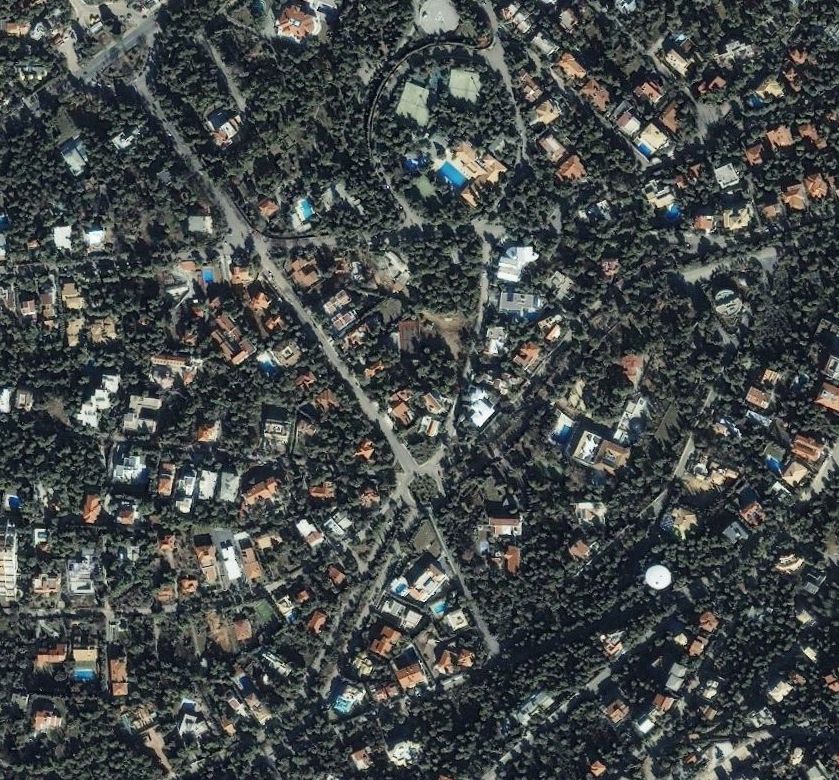

In [54]:
image1

In [55]:
fragment_width = image1.width // 200
fragment_height = image1.height // 200

In [56]:
def cut_image_into_fragments(image, fragment_width, fragment_height, predict=False, classifier=None):
    fragments = []
    r = [] # index (from left) where pool is present
    c = [] # index (from top) where pool is present
    for y in range(0, image.height // fragment_height):  # - to adjust for indexing and paritioning
        for x in range(0, image.width // fragment_width): # - to adjust for indexing and paritioning
            x1 = x*fragment_width
            x2 = x1 + fragment_width
            y1 = y*fragment_height
            y2 = y1 + fragment_height
            fragment = image.crop((x1, y1, x2, y2)) # left, top, left+w, top + h
            fragments.append(fragment)
            if predict:
              prediction = classifier.predict(np.array(fragment).reshape(-1,36)) #-1,36
              if prediction ==1 :
                r.append(x1)
                c.append(y1)
    if predict:
      return fragments, r, c
    return fragments

In [57]:
fragments1 = cut_image_into_fragments(image1, fragment_width, fragment_height)
fragments2 = cut_image_into_fragments(image2, fragment_width, fragment_height)

In [58]:
fragment_arrays1 = np.array([np.array(fragment) for fragment in fragments1])
fragment_arrays2 = np.array([np.array(fragment) for fragment in fragments2])

In [59]:
left = (164/(164+65)) *image1.width  # trial & error
top = (75/(75+138)) *image1.height
blue = image1.rotate(-50).crop((left, top, left + fragment_width, top + fragment_height))
display(blue)
blue_array = np.array(blue)

In [60]:
blue_array.shape

(3, 4, 3)

In [61]:
from skimage.metrics import structural_similarity

blue_array = np.array(blue)
training_images = []
ssims = []
for idx in range(fragment_arrays1.shape[0]):
  ssim = structural_similarity(blue_array, fragment_arrays1[idx], win_size=3, channel_axis =2)
  ssims.append(ssim)

In [62]:
training_images = []
for ssim,idx in zip(ssims, range(fragment_arrays1.shape[0])):
  if ssim > 0.6:
    training_images.append(fragment_arrays1[idx])
print(len(training_images))

31


In [65]:
structural_similarity(blue_array, blue_array, channel_axis =2, win_size=3)

1.0

In [66]:
if len(training_images)<100:
  for img in training_images:
    display(Image.fromarray(img))

In [67]:
blue_training_images = []
for img_arr in training_images[8:14]: #[-15:-9]:
  display(Image.fromarray(img_arr))
  blue_training_images.append(img_arr)

In [68]:
non_blue_training_images = []
for ssim,idx in zip(ssims, range(fragment_arrays1.shape[0])):
  if ssim > -1 and ssim< 0.6:
    non_blue_training_images.append(fragment_arrays1[idx])
print(len(non_blue_training_images))

54309


In [69]:
blue_training_images_upsampled = []
for i in range(9095):
  blue_training_images_upsampled.append(blue_training_images)

In [70]:
len(blue_training_images_upsampled)

9095

In [71]:
positive_class = np.array(blue_training_images_upsampled).reshape(-1,3,4,3)
negative_class = np.array(non_blue_training_images)

In [72]:
negative_class.shape, positive_class.shape

((54309, 3, 4, 3), (54570, 3, 4, 3))

In [73]:
np.ones(positive_class.shape[0])

array([1., 1., 1., ..., 1., 1., 1.])

In [74]:
positive_class.shape, negative_class.shape

((54570, 3, 4, 3), (54309, 3, 4, 3))

In [75]:
base_estimator2 = Perceptron(max_iter=100, verbose=0)
n_estimators2 = 20  # Number of weak classifiers
adaboost2 = AdaBoostClassifier(estimator=base_estimator2, n_estimators=n_estimators2, algorithm='SAMME')
adaboost2.fit(np.concatenate((positive_class.reshape(-1, 36), negative_class.reshape(-1, 36)), axis=0), np.concatenate((np.ones((positive_class.shape[0]), dtype=np.uint8), (-1*np.ones((negative_class.shape[0]), dtype=np.uint8)))))

AdaBoostClassifier(algorithm='SAMME', estimator=Perceptron(max_iter=100),
                   n_estimators=20)

In [76]:
y_pred2 = adaboost2.predict(positive_class.reshape(-1, 36))
accuracy2 = accuracy_score(np.ones((positive_class.shape[0]), dtype=np.uint8), y_pred2)
print(f"Accuracy on blue class: {accuracy2}")

y_pred2 = adaboost2.predict(negative_class.reshape(-1, 36))
accuracy2 = accuracy_score((-1*np.ones((negative_class.shape[0]), dtype=np.uint8)), y_pred2)
print(f"Accuracy on non-blue class: {accuracy2}")

alpha_values = adaboost2.estimator_weights_
print("Alpha values for the Peceptron stumps:", alpha_values)

Accuracy on blue class: 1.0
Accuracy on non-blue class: 1.0
Alpha values for the Peceptron stumps: [9.40068521 1.53961433 1.36253807 1.79675988 7.79803498 1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


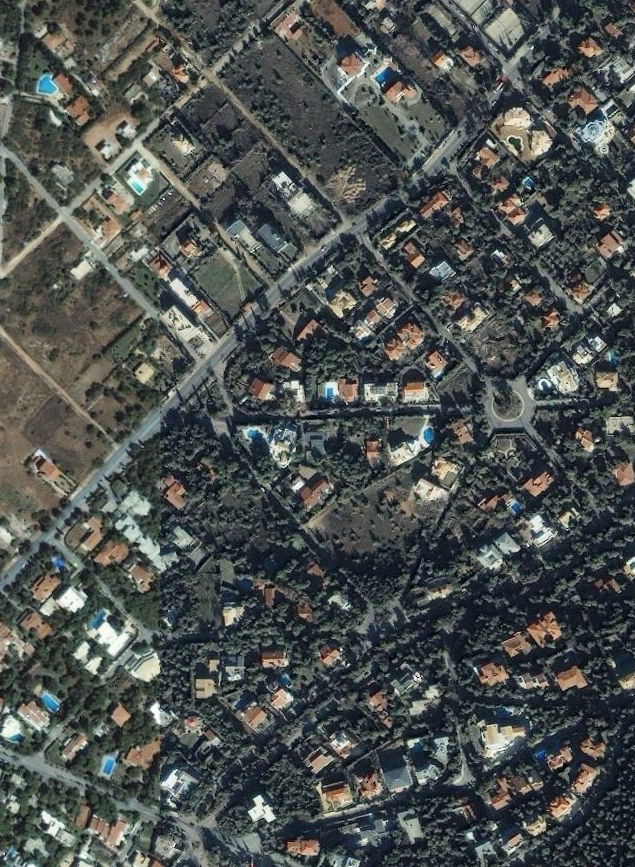

In [77]:
image2

In [78]:
fragments2, list_r, list_c = cut_image_into_fragments(image2, fragment_width, fragment_height, predict=True, classifier=adaboost2)

In [79]:
assert (image2.width//fragment_width*image2.height//fragment_height) == len(fragments2)

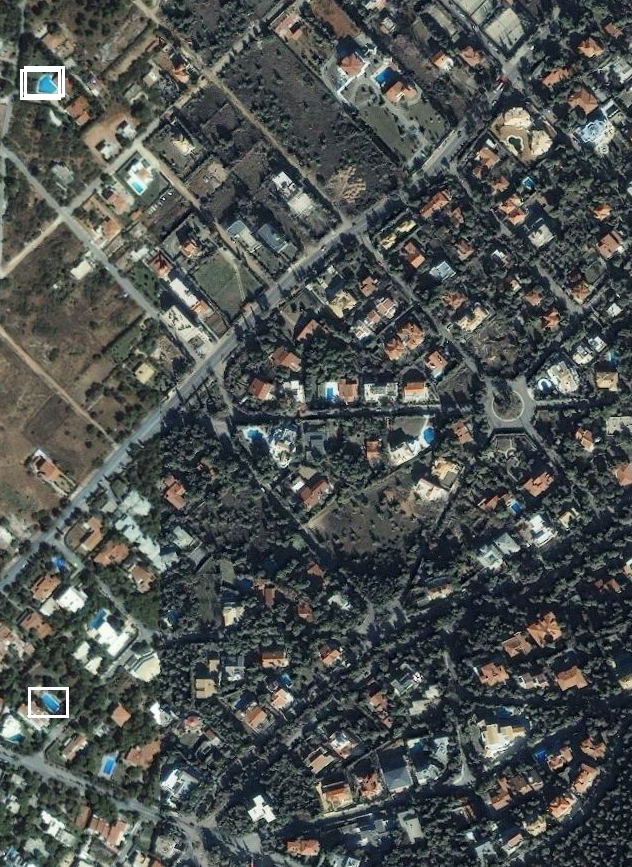

In [80]:
num_cols = image2.size[0] // fragment_width  # Adjust this based on your fragments
num_rows = image2.size[1] // fragment_height  # Adjust this based on your fragments

# Create an empty canvas to reconstruct the image
reconstructed_image = Image.new("RGB", (num_cols*fragment_width, num_rows*fragment_height), (0, 0, 0))

for row in range(num_rows):
    for col in range(num_cols):
        fragment = fragments2[row * num_cols + col]
        x = col * fragment_width
        y = row * fragment_height
        #if (x,y) in zip(list_r, list_c):
          #continue
        reconstructed_image.paste(fragment, (x, y))

segmentation_box_size = (10 * fragment_width, 10 * fragment_height)  # Size of the segmentation box

draw = ImageDraw.Draw(reconstructed_image)
for r, c in zip(list_r, list_c):
    # coordinates for the top-left and bottom-right corners of the segmentation box
    x1 = r - segmentation_box_size[0]//2
    y1 = c - segmentation_box_size[1]//2
    x2 = x1 + segmentation_box_size[0]
    y2 = y1 + segmentation_box_size[1]

    draw.rectangle([(x1, y1), (x2, y2)], outline=(255, 255, 255), width=3)

display(reconstructed_image)

#reconstructed_image.save("reconstructed_image_with_masks.jpg")


It can be seen that the through the classifier has high precision, it has very low recall, which might not be the best case in detecting pools. Could tune the parameters, or increase variety in the _blue_training_set_ to detect the other (darker blue) pools